#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import time
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
df.sort_index(inplace=True)
display(df.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Пропусков нет. Данные отсортированы по дате. Есть данные о количестве заказов в период с 1 марта 2018 года по 31 августа 2018 года. Данные о количестве заказов (колонка **num_orders**) - целые числа.

In [4]:
print(df['num_orders'].min(), df['num_orders'].max())

0 119


Минимальное кол-во заказов 0 , максимальное - 119. Аномальных данных нет.

## Анализ

Т.к. требуется предсказать количество заказов на следующий час, то сделаем ресемплирование данных по одному часу

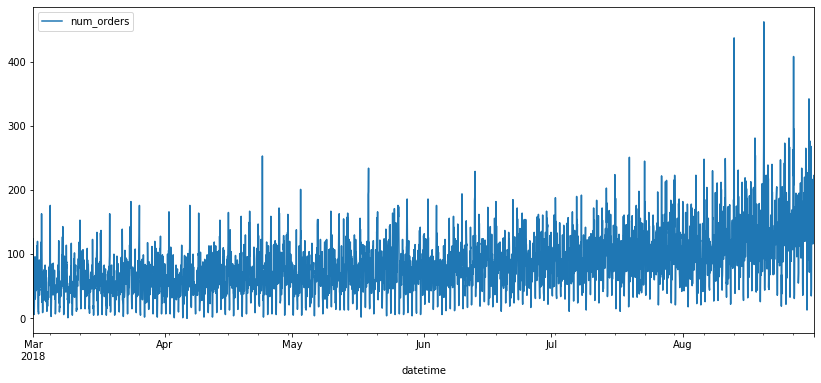

In [5]:
df=df.resample('1H').sum()
df.plot(figsize = (14,6))
plt.show()

Временной ряд не стационарен. Со временем меняется его среднее значение и дисперсия

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


Количество строк после ресемплирования стало меньше. Посмотрим на тренды и сезонность в данных

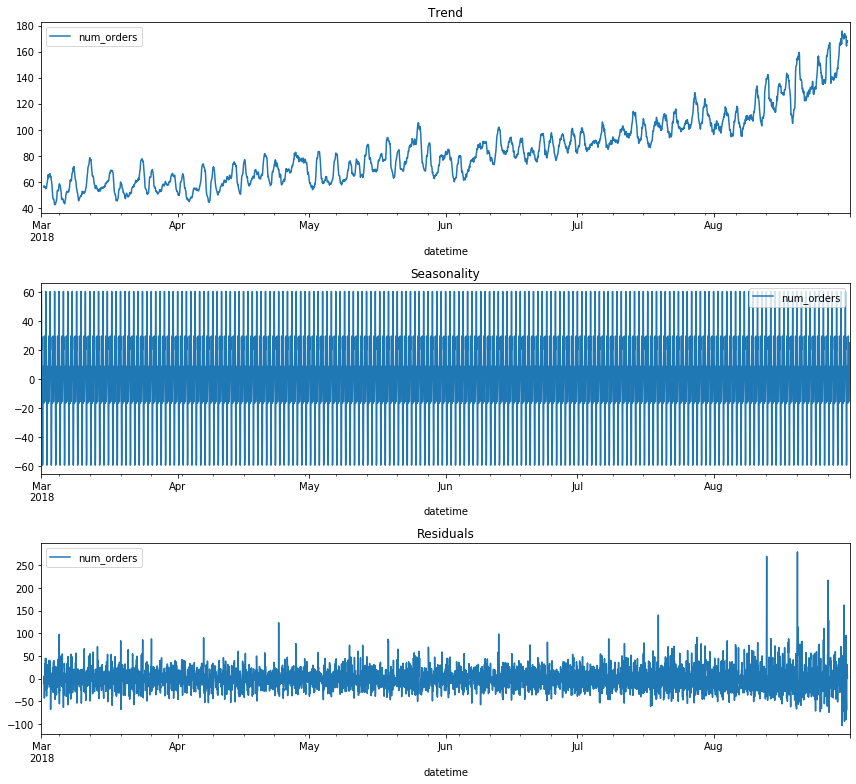

In [7]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(12, 11))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Данных очень много и трудно сделать вывод. Только прослеживается тренд к заметному увеличению количества заказов с мая. Посмотрим на тренды и сезонность за последние 2 недели

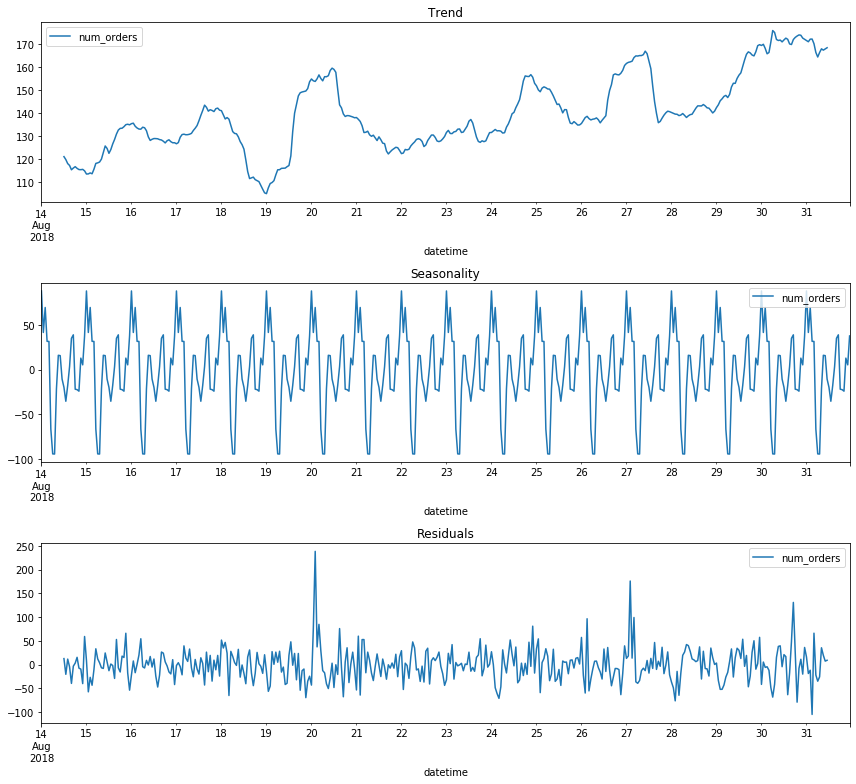

In [8]:
decomposed = seasonal_decompose(df['2018-08-14':'2018-08-31'])
plt.figure(figsize=(12, 11))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

На графике сезонности распределение в рамках дня выглядит статическим. Ночью закзов очень мало. Больше всего заказов к вечеру. Такой ряд можно прогнозировать.

## Обучение

Напишем функцию для создания признаков. Для признаков понадобятся год, месяц, день и день недели, а также скользящее среднее rolling_mean и размер смещения lag

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    df['year'] = data.index.month
    df['month'] = data.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    for lag in range(1, max_lag+1):
        df['lag_{}'.format(lag)]= df['num_orders'].shift(lag)
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

Посмотрим какая метрика RMSE получается у константной модели. Построим константную модель 2-х видов. 

1.Константая модель, которая прогнозирует предыдущее значение

In [10]:
train_const, test_const = train_test_split(df, shuffle=False, test_size=0.1)
pred_previous = test_const.shift()
pred_previous.iloc[0] = train_const.iloc[-1]
rmse_const= mean_squared_error(test_const,pred_previous)**0.5
print("RMSE константной модели: {:.2f}". format(rmse_const))

RMSE константной модели: 58.86


2.Константая модель, которая прогнозирует среднее значение

In [11]:
pred_median = np.ones(test_const.shape)*train_const['num_orders'].mean()
rmse_const_mean= mean_squared_error(test_const,pred_median)**0.5
print("RMSE константной модели: {:.2f}". format(rmse_const_mean))

RMSE константной модели: 84.74


Будем сравнивать все модели с моделью, которая прогнозирует предыдущее значение. RMSE = 58

**Произвольные параметры**

Посмотрим какая получится метрика RMSE, если взять произвольные параметры для создания признаков (размер смещения и размер скользящего окна) и произвольные гиперпараметры для моделей

In [12]:
df_upd=make_features(df, 50, 40)
df_upd.shape

(4416, 56)

In [13]:
train,test = train_test_split(df_upd, shuffle=False, test_size=0.1)
train=train.dropna()
print(train.shape, test.shape)

(3924, 56) (442, 56)


In [14]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [15]:
print(features_train.shape, target_train.shape)

(3924, 55) (3924,)


Разделение корректное

Напишем функцию для обучения модели и прогнозирования на тестовой выборке. Возьмем 4 модели: Линейная регрессия, Случайный лес, Лассо и CatBoost

In [16]:
def model_random(model):
    model.fit(features_train, target_train)
    test_pred=model.predict(features_test)
    rmse_test=(mean_squared_error(target_test,test_pred))**0.5 
    print('RMSE тестовой выборки: {:.2f}'.format(rmse_test))

**Линейная регрессия**

In [17]:
line = LinearRegression()
model_random(line)

RMSE тестовой выборки: 43.18


**Случайный лес**

In [18]:
forest = RandomForestRegressor(max_depth=3)
model_random(forest)

RMSE тестовой выборки: 52.53


**Лассо**

In [19]:
lasso= Lasso(alpha=0.1 )
model_random(lasso)

RMSE тестовой выборки: 42.95


**CatBoost**

In [20]:
cat = CatBoostRegressor(iterations=100, verbose=False, learning_rate=0.3, depth=3)
model_random(cat)

RMSE тестовой выборки: 41.98


С произвольными параметрами у всех моделей метрика RMSE лучше, чем у константой модели, но только у трех моделей метрика ниже порога в 48. У Случайного дерева метрика выше 48. Посмотрим, получится ли улучшить метрику если подобрать другие параметры.   

**С подбором параметров**

**Линейная регрессия**

In [21]:
%%time
best_lag=0
best_rolling_size = 0
best_rmse=48
for lag in range (1, 100, 10):
    for roll in range(1,100,10):
        
        df_new =make_features(df, lag, roll)
        train, test=train_test_split(df_new, shuffle=False, test_size=0.1)
        train=train.dropna()
        features_train = train.drop(['num_orders'], axis=1)
        target_train = train['num_orders']
        features_test = test.drop(['num_orders'], axis=1)
        target_test =test['num_orders']
        
        regress = LinearRegression()
        tss = TimeSeriesSplit(n_splits = 2)
        regress_params={'normalize':[True,False]}
        grid= GridSearchCV(regress, regress_params, scoring='neg_mean_squared_error',  cv=tss , n_jobs = -1)
        grid.fit(features_train, target_train)
        rmse=(-grid.best_score_)**0.5   
        if rmse < best_rmse:
            best_rmse=rmse
            best_lag=lag
            best_rolling_size = roll
        
            
print('RMSE на кроссвалидации: {:.2f}, Размер смещения: {:.2f}, Размер скользящего окна: {:.2f} '.format(best_rmse, best_lag,best_rolling_size))
print('Наилучшие параметры для модели:', grid.best_params_)

RMSE на кроссвалидации: 25.39, Размер смещения: 81.00, Размер скользящего окна: 11.00 
Наилучшие параметры для модели: {'normalize': False}
CPU times: user 1min 6s, sys: 1min 23s, total: 2min 30s
Wall time: 2min 31s


У Линейной регресии на кроссвалидации RMSE = 25.39 с параметрами: Размер смещения= 81.00, Размер скользящего окна= 11.00 и гиперпараметром normalize=False

**Случайный лес**

In [23]:
%%time
best_lag=0
best_rolling_size = 0
best_rmse=48
for lag in range (1, 100, 10):
    for roll in range(1,100,10):
        df_new =make_features(df, lag, roll)
        train, test=train_test_split(df_new, shuffle=False, test_size=0.1)
        train=train.dropna()
        features_train = train.drop(['num_orders'], axis=1)
        target_train = train['num_orders']
        features_test = test.drop(['num_orders'], axis=1)
        target_test =test['num_orders']
        
        forest = RandomForestRegressor()
        tss = TimeSeriesSplit(n_splits = 2)
        forest_params={'max_depth': range(1, 21, 5)}
        grid= GridSearchCV(forest,forest_params, scoring='neg_mean_squared_error',  cv=tss , n_jobs = -1)
        grid.fit(features_train, target_train)
        rmse=(-grid.best_score_)**0.5 
        if rmse < best_rmse:
            best_rmse=rmse
            best_lag=lag
            best_rolling_size = roll
        
            
print('RMSE на кроссвалидации: {:.2f}, Размер смещения: {:.2f}, Размер скользящего окна: {:.2f} '.format(best_rmse, best_lag,best_rolling_size))
print('Наилучшие параметры для модели:', grid.best_params_)

RMSE на кроссвалидации: 26.63, Размер смещения: 61.00, Размер скользящего окна: 1.00 
Наилучшие параметры для модели: {'max_depth': 6}
CPU times: user 10min 55s, sys: 0 ns, total: 10min 55s
Wall time: 10min 57s


У Случайного лесa на кроссвалидации RMSE = 26.63 с параметрами: Размер смещения= 61.00, Размер скользящего окна= 1.00 и гиперпараметром max_depth=6

**Лассо**

In [25]:
%%time

best_lag=0
best_rolling_size = 0
best_rmse=48
for lag in range (1, 101, 10):
    for roll in range(1, 101, 10):
        df_new =make_features(df, lag, roll)
        train, test=train_test_split(df_new, shuffle=False, test_size=0.1)
        train=train.dropna()
        features_train = train.drop(['num_orders'], axis=1)
        target_train = train['num_orders']
        features_test = test.drop(['num_orders'], axis=1)
        target_test =test['num_orders']
        lasso= Lasso()
        tss = TimeSeriesSplit(n_splits = 2)
        lasso_params={'alpha': [0.1, 0.5, 1]} 
        grid= GridSearchCV(lasso,lasso_params, scoring='neg_mean_squared_error',  cv=tss , n_jobs = -1)
        grid.fit(features_train, target_train)
        rmse=(-grid.best_score_)**0.5
        if rmse < best_rmse:
            best_rmse=rmse
            best_lag=lag
            best_rolling_size = roll
                
            
print('RMSE тестовой выборки: {:.2f}, Размер смещения: {:.2f}, Размер скользящего окна: {:.2f} '.format(best_rmse, best_lag,best_rolling_size))
print('Наилучшие параметры для модели:', grid.best_params_)

RMSE тестовой выборки: 25.57, Размер смещения: 1.00, Размер скользящего окна: 1.00 
Наилучшие параметры для модели: {'alpha': 0.1}
CPU times: user 4min 33s, sys: 3min 40s, total: 8min 14s
Wall time: 8min 14s


У Лассо на кроссвалидации RMSE = 25.57 с параметрами: Размер смещения= 1.00, Размер скользящего окна= 1.00 и гиперпараметром alpha=0.1

**CatBoost**

In [27]:
%%time
best_lag=0
best_rolling_size = 0
best_rmse=48
for lag in range (1, 101, 10):
    for roll in range(1,101,10):
        df_new =make_features(df, lag, roll)
        train, test=train_test_split(df_new, shuffle=False, test_size=0.1)
        train=train.dropna()
        features_train = train.drop(['num_orders'], axis=1)
        target_train = train['num_orders']
        features_test = test.drop(['num_orders'], axis=1)
        target_test =test['num_orders']
        
        cat = CatBoostRegressor(iterations=100, verbose=False)
        tss = TimeSeriesSplit(n_splits = 2)
        cat_params = {'learning_rate':[0.1, 0.3, 0.5]}
        
        grid= GridSearchCV(cat, cat_params, scoring='neg_mean_squared_error',  cv=tss , n_jobs = -1)
        grid.fit(features_train, target_train)
        rmse=(-grid.best_score_)**0.5
        if rmse < best_rmse:
            best_rmse=rmse
            best_lag=lag
            best_rolling_size = roll
                
            
print('RMSE на кроссвалидации: {:.2f}, Размер смещения: {:.2f}, Размер скользящего окна: {:.2f} '.format(best_rmse, best_lag,best_rolling_size))
print('Наилучшие параметры для модели:', grid.best_params_)

RMSE на кроссвалидации: 26.16, Размер смещения: 1.00, Размер скользящего окна: 41.00 
Наилучшие параметры для модели: {'depth': 3, 'learning_rate': 0.1}
CPU times: user 49min 6s, sys: 5min 14s, total: 54min 21s
Wall time: 1h 16min 50s


У Случайного лесa на кроссвалидации RMSE = 26.16 с параметрами: Размер смещения= 1.00, Размер скользящего окна= 41.00 и гиперпараметрами depth=3 и learning rate= 0.1

**Вывод**. У всех моделей удалось найти парметры чтобы улучшить метрику. RMSE ниже 48

## Тестирование

Проведем тестирование моделей с найденными параметрами

**Линейная регрессия**

In [29]:
df_regress =make_features(df, 81, 11)
train, test=train_test_split(df_regress, shuffle=False, test_size=0.1)
train=train.dropna()
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test =test['num_orders']

regress_test = LinearRegression(normalize= False)
regress_test.fit(features_train, target_train)
test_pred_regress= regress_test.predict(features_test)
rmse_test_regress=(mean_squared_error(target_test,test_pred_regress))**0.5 
print('RMSE тестовой выборки: {:.2f}'.format(rmse_test_regress))

RMSE тестовой выборки: 42.82


**Случайный лес**

In [30]:
df_forest =make_features(df, 61, 1)
train, test=train_test_split(df_forest, shuffle=False, test_size=0.1)
train=train.dropna()
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test =test['num_orders']

forest_test = RandomForestRegressor(max_depth=6)
forest_test.fit(features_train, target_train)
test_pred_forest= forest_test.predict(features_test)
rmse_test_forest=(mean_squared_error(target_test,test_pred_forest))**0.5 
print('RMSE тестовой выборки: {:.2f}'.format(rmse_test_forest))

RMSE тестовой выборки: 44.18


**Лассо**

In [31]:
df_lasso =make_features(df, 1, 1)
train, test=train_test_split(df_lasso, shuffle=False, test_size=0.1)
train=train.dropna()
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test =test['num_orders']

lasso_test = Lasso(alpha=0.1)
lasso_test.fit(features_train, target_train)
test_pred_lasso= lasso_test.predict(features_test)
rmse_test_lasso=(mean_squared_error(target_test,test_pred_lasso))**0.5 
print('RMSE тестовой выборки: {:.2f}'.format(rmse_test_lasso))

RMSE тестовой выборки: 42.44


**CatBoost**

In [32]:
df_cat =make_features(df, 1, 41)
train, test=train_test_split(df_cat, shuffle=False, test_size=0.1)
train=train.dropna()
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test =test['num_orders']

cat_test = CatBoostRegressor(iterations=100, verbose=False, learning_rate=0.1, depth=3)
cat_test.fit(features_train, target_train)
test_pred_cat= cat_test.predict(features_test)
rmse_test_cat=(mean_squared_error(target_test,test_pred_cat))**0.5 
print('RMSE тестовой выборки: {:.2f}'.format(rmse_test_cat))

RMSE тестовой выборки: 40.55


Соберем все показатели в одну таблицу и найдем лучшую модель

In [33]:
data = {'Модель': ['Константная модель','Линейная регрессия' ,'Случайный лесс', 'Лассо', 'CatBoost'], 
        'RMSE на тесте': [58.86, 42.82, 44.18, 42.44, 40.55],
       'lag': [1, 81,61,1, 1],'rolling size': ['N/A',11,31,1,41 ] }
data_pivot = pd.DataFrame.from_dict(data)
display(data_pivot)

,Модель,RMSE на тесте,lag,rolling size
0,Константная модель,58.86,1,N/A
1,Линейная регрессия,42.82,81,11
2,Случайный лесс,44.18,61,31
3,Лассо,42.44,1,1
4,CatBoost,40.55,1,41


С подобранными параметрами у всех моделей метрика RMSE лучше, чем с произвольными параметрами и ниже порога в 48. Наилучший результат получился у модели CatBoost.  Посмотрим на графике как выглядят предсказания модели

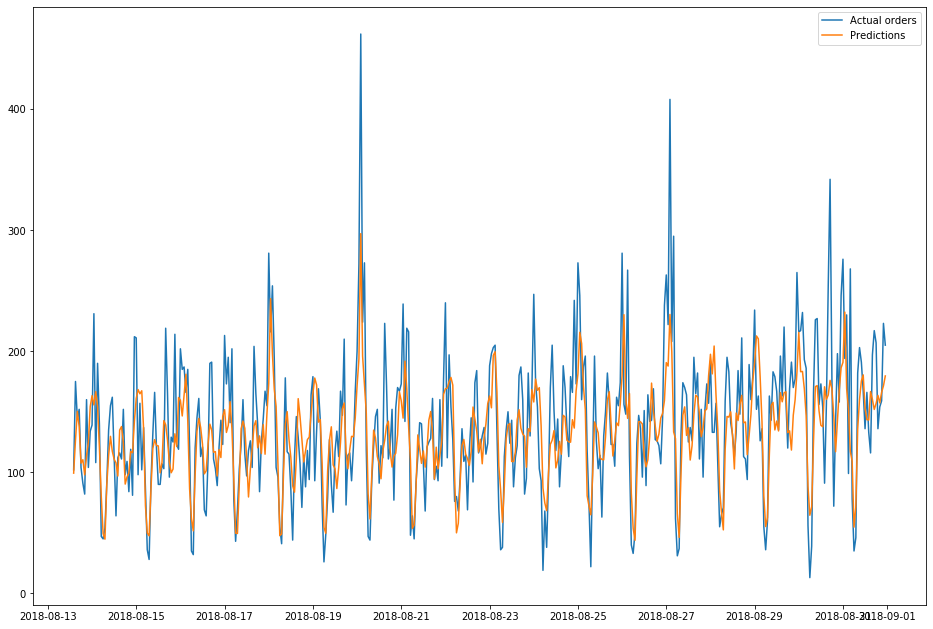

In [35]:
df_cat =make_features(df, 1, 41)
train, test=train_test_split(df_cat, shuffle=False, test_size=0.1)
train=train.dropna()
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test =test['num_orders']
cat = CatBoostRegressor(iterations=100, verbose=False, learning_rate=0.1, depth=3)
cat.fit(features_train, target_train)
test_pred= cat.predict(features_test)
plt.figure(figsize=(16, 11))
plt.plot(features_test.index, target_test, label='Actual orders')
plt.plot(features_test.index, test_pred, label='Predictions')
plt.legend()
plt.show()

По графику видно, что модель достаточно точно прогнозирует и  лишь большие пики плохо предсказывает. 

**Выводы**. 

Все модели после подбора параметров показали метрику RMSE ниже порога в 48 и ниже, чем у константной модели. Лучшая метрика RMSE получилась у модели CatBoost, однако модель плохо предсказывает большие пики. Возможно, в данных необходимо дополнительно выделять выходные и праздничные дни. 